In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras import backend as K
from keras.layers import Reshape


In [2]:
path = 'train_data/'

sg_B = np.load(path + 'sg_B.npy')
sg_C = np.load(path + 'sg_C.npy')
sg_D = np.load(path + 'sg_D.npy')
sg_E = np.load(path + 'sg_E.npy')
sg_F = np.load(path + 'sg_F.npy')
sg_G = np.load(path + 'sg_G.npy')
sg_H = np.load(path + 'sg_H.npy')
sg_I = np.load(path + 'sg_I.npy')
BDF_distance = np.load(path + 'BDF_distance.npy')


spike_A = np.load(path + 'spike_A.npy')
spike_B = np.load(path + 'spike_B.npy')
spike_C = np.load(path + 'spike_C.npy')
spike_D = np.load(path + 'spike_D.npy')
spike_abs_B = np.load(path + 'spike_abs_B.npy')
spike_abs_C = np.load(path + 'spike_abs_C.npy')
spike_abs_D = np.load(path + 'spike_abs_D.npy')

spike_B_lower_noise = np.load(path + 'spike_B_lower_noise.npy')
spike_C_lower_noise = np.load(path + 'spike_C_lower_noise.npy')
spike_abs_B_lower_noise = np.load(path + 'spike_abs_B_lower_noise.npy')
spike_abs_C_lower_noise = np.load(path + 'spike_abs_C_lower_noise.npy')

BCD_distance = np.load(path + 'BCD_distance.npy')
BCD_abs_distance = np.load(path + 'BCD_abs_distance.npy')


output1 = pd.read_csv('train1/00_Wear_data.csv').loc[:, 'MaxWear']
output2 = pd.read_csv('train2/00_Wear_data.csv').loc[:, 'MaxWear']
Output = pd.concat([output1, output2], axis=0).values


In [3]:
spike_B_sum = spike_B.sum(axis=1)
spike_C_sum = spike_C.sum(axis=1)
spike_D_sum = spike_D.sum(axis=1)

spike_B_lower_noise_sum = spike_B_lower_noise.sum(axis=1)
spike_C_lower_noise_sum = spike_C_lower_noise.sum(axis=1)

df2 = pd.DataFrame()
integrated_spike_B = [sum(abs(spike_B_sum[:i]))
                      for i in range(1, len(spike_B_sum)+1)]
df2['integrated_spike_B'] = pd.Series(integrated_spike_B)

integrated_spike_C = [sum(abs(spike_C_sum[:i]))
                      for i in range(1, len(spike_C_sum)+1)]
df2['integrated_spike_C'] = pd.Series(integrated_spike_C)

integrated_spike_D = [sum(abs(spike_D_sum[:i]))
                      for i in range(1, len(spike_D_sum)+1)]
df2['integrated_spike_D'] = pd.Series(integrated_spike_D)
""""""
integrated_spike_B_lower_noise = [sum(abs(
    spike_B_lower_noise_sum[:i]))for i in range(1, len(spike_B_lower_noise_sum)+1)]
df2['integrated_spike_B_lower_noise'] = pd.Series(
    integrated_spike_B_lower_noise)

integrated_spike_C_lower_noise = [sum(abs(
    spike_C_lower_noise_sum[:i]))for i in range(1, len(spike_C_lower_noise_sum)+1)]
df2['integrated_spike_C_lower_noise'] = pd.Series(
    integrated_spike_C_lower_noise)

df2['Output'] = pd.Series(Output)

columns = df2.columns
transformer = StandardScaler()
corr = pd.DataFrame(transformer.fit_transform(df2), columns=columns).corr()
print(corr.iloc[-1, :])


integrated_spike_B                0.210843
integrated_spike_C                0.227507
integrated_spike_D                0.229796
integrated_spike_B_lower_noise    0.234621
integrated_spike_C_lower_noise    0.246756
Output                            1.000000
Name: Output, dtype: float64


In [4]:
print(df2.columns)
Model = df2.values
Input = Model[:, :-1]
output = Model[:, -1]
output = np.reshape(output, (-1, 1))

Input_shape = Input.shape[1]

print('Input layer 0: ', Input[0, :10])
print('Output layer ~ 10: ', output[:10])

Input_transformer = MaxAbsScaler()
Output_transformer = StandardScaler()

Input = Input_transformer.fit_transform(Input)
Output = Output_transformer.fit_transform(output)

print('Input layer 0: ', Input[0, :10])

input_train, input_test, output_train, output_test = train_test_split(
    Input, output, test_size=0.1, random_state=42)
print('input_train.shape:\t', input_train.shape)
print('input_test.shape:\t', input_test.shape)
print('output_train.shape:\t', output_train.shape)
print('output_test.shape:\t', output_test.shape)

input_train = tf.convert_to_tensor(input_train)
input_test = tf.convert_to_tensor(input_test)
output_train = tf.convert_to_tensor(output_train)
output_test = tf.convert_to_tensor(output_test)

Index(['integrated_spike_B', 'integrated_spike_C', 'integrated_spike_D',
       'integrated_spike_B_lower_noise', 'integrated_spike_C_lower_noise',
       'Output'],
      dtype='object')
Input layer 0:  [25.016639   9.571132   0.99154    6.7658625  2.591525 ]
Output layer ~ 10:  [[0.10236723]
 [0.13203094]
 [0.18754876]
 [0.19920984]
 [0.22729473]
 [0.26207539]
 [0.2838152 ]
 [0.30276893]
 [0.31918277]
 [0.33329432]]
Input layer 0:  [0.01237833 0.00506804 0.00670732 0.0016116  0.00543376]
input_train.shape:	 (63, 5)
input_test.shape:	 (7, 5)
output_train.shape:	 (63, 1)
output_test.shape:	 (7, 1)


In [5]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=Input_shape))
#model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
#model.add(Dense(2, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,289
Trainable params: 1,289
Non-trainable params: 0
_________________________________________________________________


In [6]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


learning_rate = 0.0005    # 0.003 --> 0.0003    0.005 --> 0.0005
batch_size = 15
epochs = 500


# Adam RMSprop
model.compile(optimizer=tf.optimizers.Adam(
    learning_rate=learning_rate), loss=rmse)

start = time.time()
history = model.fit(input_train, output_train,
                    validation_data=(input_test, output_test), batch_size=batch_size, epochs=epochs, verbose=1)
end = time.time()

print('\n\n')
print('Training cost time:\t', end - start, 's')
print('\n\n')

Epoch 1/500
5/5 [==============================] - 1s 31ms/step - loss: 0.6114 - val_loss: 0.3768
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss: 0.5209 - val_loss: 0.3226
Epoch 3/500
5/5 [==============================] - 0s 9ms/step - loss: 0.4440 - val_loss: 0.2793
Epoch 4/500
5/5 [==============================] - 0s 8ms/step - loss: 0.3811 - val_loss: 0.2640
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 0.3670 - val_loss: 0.2425
Epoch 6/500
5/5 [==============================] - 0s 8ms/step - loss: 0.3293 - val_loss: 0.1937
Epoch 7/500
5/5 [==============================] - 0s 10ms/step - loss: 0.2532 - val_loss: 0.1400
Epoch 8/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1713 - val_loss: 0.1299
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1550 - val_loss: 0.1302
Epoch 10/500
5/5 [==============================] - 0s 9ms/step - loss: 0.1500 - val_loss: 0.1299
Epoch 11/500
5/5 [=========

In [7]:
def numpy_rmse(actual, predict):
    return pow(np.mean(pow(actual - predict, 2)), 0.5)


test_predict = model.predict(input_test)
test_predict_actual = output_test.numpy()

test_predict = np.array(test_predict)
print(list(test_predict))

test_predict = Output_transformer.inverse_transform(test_predict)
test_predict_actual = Output_transformer.inverse_transform(test_predict_actual)

test_RMSE = numpy_rmse(test_predict_actual, test_predict)
print('Test: ')
print('Test RMSE:\t', test_RMSE)
print()

###############################################################

train_predict = model.predict(input_train)
train_predict_actual = output_train.numpy()

train_predict = Output_transformer.inverse_transform(train_predict)
train_predict_actual = Output_transformer.inverse_transform(
    train_predict_actual)

train_RMSE = numpy_rmse(train_predict_actual, train_predict)
print('\n\n\n')
print('Train: ')
print('Train RMSE:\t', train_RMSE)

1/1 [==============================] - 0s 44ms/step
[array([0.40039074], dtype=float32), array([0.20891806], dtype=float32), array([0.4143368], dtype=float32), array([0.25065908], dtype=float32), array([0.40141162], dtype=float32), array([0.38807118], dtype=float32), array([0.34818488], dtype=float32)]
Test: 
Test RMSE:	 0.011165182767978002

2/2 [==============================] - 0s 2ms/step




Train: 
Train RMSE:	 0.01049343405798452


In [10]:
total_predict = model.predict(Input)
total_predict_actual = output

total_predict = Output_transformer.inverse_transform(total_predict)
total_predict_actual = Output_transformer.inverse_transform(
    total_predict_actual)

total_RMSE = numpy_rmse(total_predict_actual, total_predict)
print('\n\n\n')
print('Total: ')
print('Total RMSE:\t', total_RMSE)
# print('Total actual:\t', total_predict_actual.T)
# print('Total predict:\t', total_predict.T)

"""
print('Total actual:')
for i in total_predict_actual:
        print(i[0], ', ', end='')
print('\nTotal predict:')
for i in total_predict:
        print(i[0], ', ', end='')
"""


3/3 [==============================] - 0s 2ms/step




Total: 
Total RMSE:	 0.010562531645971205


"\nprint('Total actual:')\nfor i in total_predict_actual:\n        print(i[0], ', ', end='')\nprint('\nTotal predict:')\nfor i in total_predict:\n        print(i[0], ', ', end='')\n"

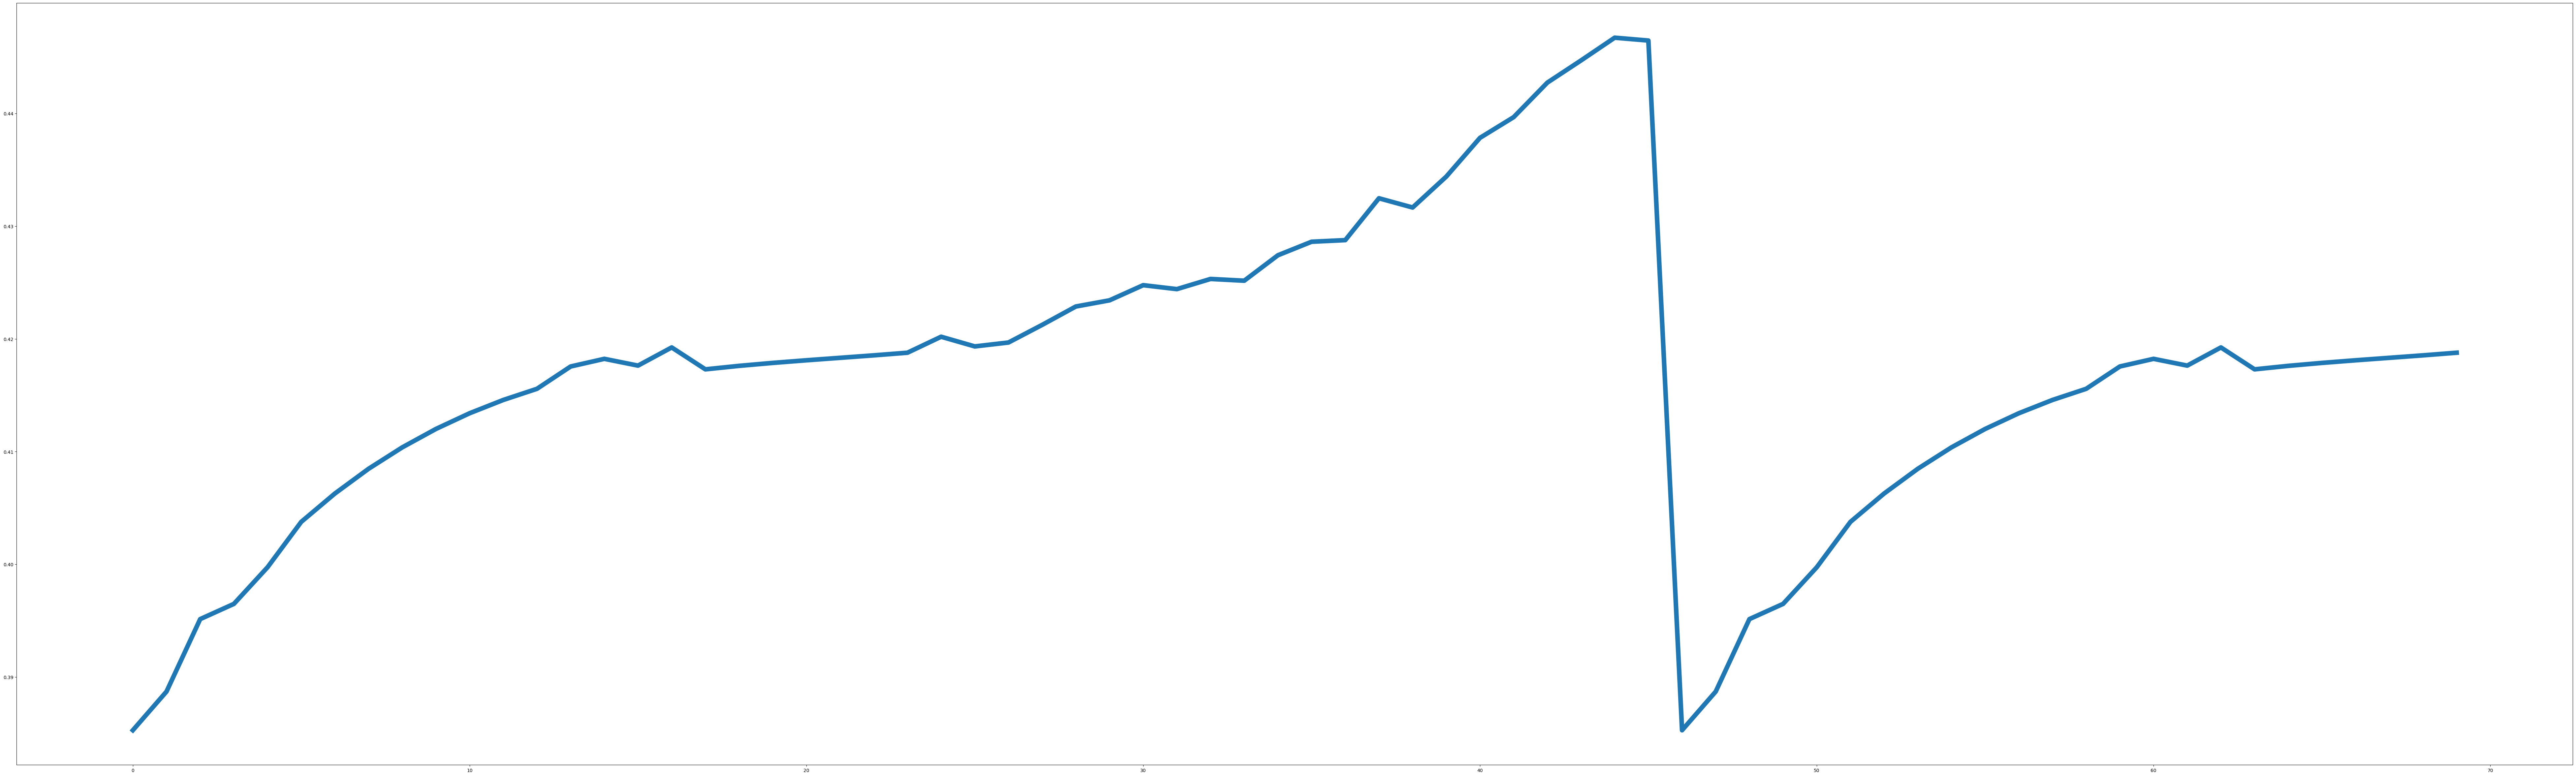

In [12]:
fig, ax1 = plt.subplots(figsize=(100, 30))
plt.plot(total_predict_actual, linewidth=10.0)
# plt.plot(total_predict, color='orange', linewidth=10.0)
